In [1]:
import numpy as np
import pandas as pd

import obspy


import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from time import localtime, strftime

%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, BatchNormalization, add
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from numpy.fft import fft, ifft
from tensorflow.keras.utils import to_categorical
from scipy.special import softmax
from scipy.signal import lfilter, butter, decimate

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from math import radians, degrees, cos, sin


model_folder = 'models/'
log_folder = 'logs/'

In [2]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):

    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def base_model(win_len, nb_chan, nb_filters, filter_len, dilations, nb_stacks,
               padding='same', drop=0.05):

    input_layer = Input(shape=(win_len, nb_chan))
    orig_data, mask = tf.split(input_layer, 2, 2)
    
    x = input_layer
    x = Convolution1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)
    
    x = Dense(1)(x)
    
    predict = orig_data + x * (1.-mask)
    output_layer = tf.concat([predict, mask], 2)
    model = Model(input_layer, output_layer)

    return model

In [17]:
x = np.load('data/data.npy').astype('float32')


# Model Parameters
pdict = {}
pdict['f']     = 10
pdict['k']     = 15
pdict['d']     = [2, 4, 8, 16, 32]
pdict['s']     = 1

# Dataset Parameters
pdict['flo']   = .3
pdict['fhi']   = 5
pdict['wlen']  = 180
pdict['glen']  = 1
pdict['gskp']  = 30
pdict['fsorig'] = 40
pdict['fs']    = 100


# Training Parameters
pdict['bs']    = 3
pdict['lr']    = .0005
pdict['pat']   = 3
pdict['time']  = strftime("%y-%m-%d-%H-%M-%S", localtime())


In [4]:
def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data) 


In [9]:
def upsample(x, fs_old, fs_new):
    win_len = len(x)/fs_old
    t_old = np.linspace(0, int(win_len-1/fs_old), int(win_len*fs_old))
    t_new = np.linspace(0, int(win_len-1/fs_new), int(win_len*fs_new))
    x = np.interp(t_new, t_old, x)
    return x

In [10]:
def gen(x, pdict, rand=1):
    g_len = int(pdict['glen'] * pdict['fs'])
    g_skp = int(pdict['gskp'] * pdict['fs'])
    x = butter_bandpass_filter(x, pdict['flo'], pdict['fhi'], fs=pdict['fsorig'])
    x_resamp = []
        
    for i in range(len(x)):
        x_resamp.append(upsample(x[i], pdict['fsorig'], pdict['fs']))
    
    x = np.vstack(x_resamp)
    while 1:
        my_y = np.expand_dims(x[np.random.randint(x.shape[0], size=pdict['bs']),:], 2)
        mask = np.ones(my_y.shape)
        
        my_y = np.concatenate([my_y, mask], 2)
        my_x = np.copy(my_y)
        
        for idx in [g_skp * i + rand*int(np.random.randint(g_skp)/2) for i in range(1, int(my_y.shape[1]/g_skp))]:
            my_x[:, idx:idx+g_len, :] = 0
            my_y[:, idx:idx+g_len, 1] = 0
            
        #my_y = my_y[:,:,:1]
        yield my_x, my_y

In [11]:
trn_gen = gen(x[:10000], pdict)
val_gen = gen(x[10000:], pdict)

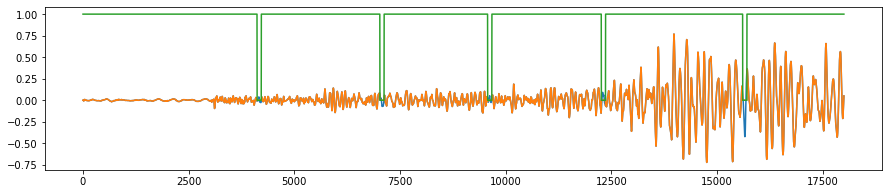

In [25]:
X, Y = next(trn_gen)
            
fig, ax = plt.subplots(1,1, figsize=(15,3))
ax.plot(Y[0,:,0])
ax.plot(X[0,:,0])
ax.plot(Y[0,:,1])

In [13]:
def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)
           
                        
def name2param(name):
    name = name[:-3]
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

In [18]:
def get_loss(alpha=1):
    def mse_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    
    def trimmed_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        diff = math_ops.squared_difference(y_pred, y_true)
        diff = tf.boolean_mask(diff, 1-mask[0,:,0], axis=1)
        return K.mean(diff, axis=1)
    
    def weighted_loss(y_true, y_pred):
        y_true, mask = tf.split(y_true, 2, 2)
        y_pred, mask = tf.split(y_pred, 2, 2)
        diff = math_ops.squared_difference(y_pred, y_true)
        w = tf.nn.convolution(mask[:1], tf.ones((50, 1, 1)), padding='SAME')
        w = w / K.max(w) * 2 + 1
        diff = diff * w
        diff = tf.boolean_mask(diff, 1-mask[0,:,0], axis=1)
        return K.mean(diff, axis=1)

    return weighted_loss


def load_custom_model(pdict, model_folder='models'):
    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f"|time:{pdict['iniW']}" in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        my_loss = get_loss()
        model = load_model(model_file, custom_objects={'mse_loss': my_loss})
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)
        
        print('building new model:\n', model_file)
        model = base_model(win_len=None,
                           nb_chan=2,
                           nb_filters=pdict['f'],
                           filter_len=pdict['k'],
                           dilations=pdict['d'],
                           nb_stacks=pdict['s'])
    return model, model_name


def compile_custom_model(model, pdict):
    o = Adam(lr=pdict['lr'], clipnorm=1.)
    my_loss = get_loss()                  
    model.compile(loss=my_loss, optimizer=o, metrics=['mae'])

    return model, param2name(pdict)


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]



In [19]:
t_step = 500
v_step = 100

In [20]:
# Build the Model
print('loading model...', end=' ', flush=True)
model, model_name = load_custom_model(pdict)

pdict = name2param(model_name)


model, _ = compile_custom_model(model, pdict)
print('complete')
print(model.summary())

model, model_name = compile_custom_model(model, pdict)
print(model_name)
model_id = pdict['time']

loading model... building new model:
 models/f:10|k:15|d:2x4x8x16x32|s:1|flo:0.3|fhi:5|wlen:180|glen:1|gskp:30|fsorig:40|fs:100|bs:3|lr:0.0005|pat:3|time:22-02-12-08-41-49
complete
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, None, 10)     30          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, None, 10)     1510        conv1d_16[0][0]                  
__________________________________________________________________________________________________
activation

In [21]:
history = model.fit_generator(trn_gen, steps_per_epoch=t_step, epochs=5000,
                              validation_data=val_gen, validation_steps=v_step,
                              callbacks=get_callbacks(model_name, model_folder, log_folder),
                              max_queue_size=10)

/home/dickey/anaconda3/envs/aiml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/dickey/anaconda3/envs/aiml/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5000
500/500 [==============================] - 70s 134ms/step - loss: 0.0214 - mae: 0.0013 - val_loss: 0.0180 - val_mae: 0.0011
Epoch 2/5000
500/500 [==============================] - 65s 130ms/step - loss: 0.0167 - mae: 0.0011 - val_loss: 0.0159 - val_mae: 0.0010
Epoch 3/5000
500/500 [==============================] - 65s 130ms/step - loss: 0.0145 - mae: 0.0010 - val_loss: 0.0162 - val_mae: 0.0010
Epoch 4/5000
500/500 [==============================] - 65s 130ms/step - loss: 0.0142 - mae: 0.0010 - val_loss: 0.0149 - val_mae: 9.8589e-04
Epoch 5/5000
500/500 [==============================] - 65s 130ms/step - loss: 0.0136 - mae: 9.9768e-04 - val_loss: 0.0152 - val_mae: 9.8470e-04
Epoch 6/5000
500/500 [==============================] - 65s 130ms/step - loss: 0.0136 - mae: 9.9035e-04 - val_loss: 0.0126 - val_mae: 8.9032e-04
Epoch 7/5000
500/500 [==============================] - 65s 129ms/step - loss: 0.0133 - mae: 9.8843e-04 - val_loss: 0.0129 - val_mae: 9.2252e-04
Epoch 8/5000


In [22]:
val_gen = gen(x[10000:], pdict, rand=0)
X, Y = next(val_gen)
Z = model.predict(X)

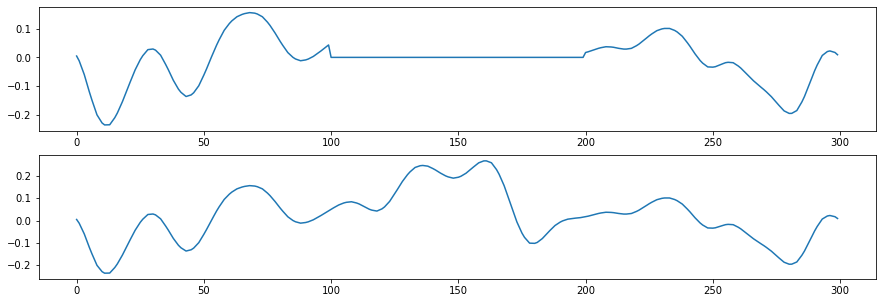

In [23]:
fig, ax = plt.subplots(2,1,figsize=(15,5))

ax[0].plot(X[0,5900:6200,0])
ax[1].plot(Y[0,5900:6200,0])


plt.savefig('seismogap.jpg')

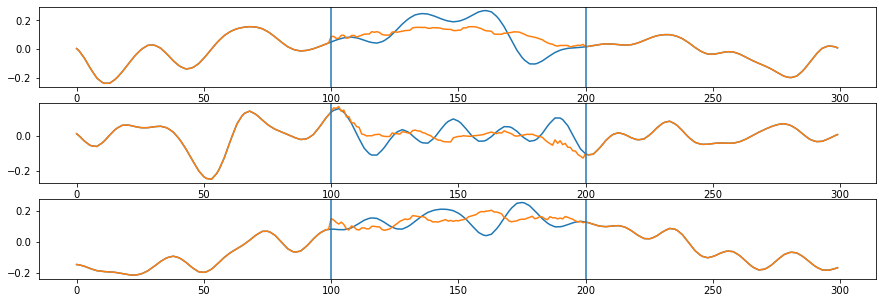

In [24]:
fig, ax = plt.subplots(3,1,figsize=(15,5))

for i in range(3):
    ax[i].plot(Y[i,5900:6200,0])
    ax[i].plot(Z[i,5900:6200,0])
    ax[i].axvline(100)
    ax[i].axvline(200)

plt.savefig('seismogap.jpg')

In [18]:
pdict['bs'] = 10000
trn_gen = gen(x[:10000], pdict)
X, Y = next(trn_gen)
Z = model.predict(X)

print('saving files...')
np.save('disc_Z', Z)
np.save('disc_Y', Y)